In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from numpy.random import randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as td
import matplotlib.pyplot as plt
import matplotlib
from collections import OrderedDict
import torch.utils.data as data

import datasets as D

import tqdm
from scipy.stats import gaussian_kde

In [2]:
noise_dim = 2
sn = nn.utils.spectral_norm

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 2)
        )
    
    def forward(self, z):
        return self.net(z)
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            sn(nn.Linear(2, 100)),
            nn.LeakyReLU(),
            sn(nn.Linear(100, 100)),
            nn.LeakyReLU(),
            sn(nn.Linear(100, 1))
        )
        
    def forward(self, x):
        return self.net.forward(x)


In [3]:
from sklearn.metrics.pairwise import euclidean_distances

def mmd(X, Y):
    dxy = euclidean_distances(X, Y) / X.shape[1]
    dxx = euclidean_distances(X, X) / X.shape[1]
    dyy = euclidean_distances(Y, Y) / X.shape[1]
    kxy = np.exp(-dxy ** 2)
    kxx = np.exp(-dxx ** 2)
    kyy = np.exp(-dyy ** 2)
    return kxx.mean() + kyy.mean() - 2 * kxy.mean()


In [4]:
from collections import OrderedDict
name_to_dataset = OrderedDict([
    ('grid', D.Grid),
    ('banana', D.Banana),
    ('rings', D.Ring),
    ('uniform', D.Uniform),
    ('cosine', D.Cosine),
    ('funnel', D.Funnel)
])


lld_dict = {}
mmd_dict = {}

for k, v in name_to_dataset.items():
    print(k)
    samples = v().sample(5000)

    for lt in ['hinge', 'kl']:
        for i in [0, 1, 2, 3]:
            key = f'{k}_{lt}'
            if key not in lld_dict.keys():
                lld_dict[key] = []
                mmd_dict[key] = []
            G_x = np.load(f'save_{i}/{k}_{lt}.npy')
            qx = gaussian_kde(G_x.T, bw_method='scott')
            lld_dict[key].append(qx.logpdf(samples.T).mean())
            mmd_dict[key].append(mmd(G_x, samples))




grid
banana
rings
uniform
cosine
funnel


In [5]:
for lt in ['hinge', 'kl']:
    s = ''
    for k, v in name_to_dataset.items():
        key = f'{k}_{lt}'
        va = lld_dict[key][:2]
        fn = np.mean
        s += f' & ${fn(va):.2f} \\pm {np.std(va) / np.sqrt(len(va)):.2f}$ '
    print(s + '\\\\')
    
for lt in ['hinge', 'kl']:
    s = ''
    for k, v in name_to_dataset.items():
        key = f'{k}_{lt}'
        va = mmd_dict[key]
        va = np.array(va) * 1000
        
        s += f' & ${np.mean(va):.2f} \\pm {np.std(va) / np.sqrt(len(va)):.2f}$ '
    print(s + '\\\\')

 & $-2.61 \pm 0.03$  & $-3.59 \pm 0.00$  & $-4.26 \pm 0.01$  & $-3.71 \pm 0.01$  & $-3.99 \pm 0.01$  & $-3.57 \pm 0.00$ \\
 & $-2.54 \pm 0.00$  & $-3.61 \pm 0.03$  & $-4.25 \pm 0.00$  & $-3.71 \pm 0.01$  & $-3.98 \pm 0.00$  & $-3.57 \pm 0.00$ \\
 & $21.70 \pm 5.77$  & $2.94 \pm 0.59$  & $2.25 \pm 0.42$  & $2.05 \pm 0.40$  & $1.23 \pm 0.40$  & $1.27 \pm 0.27$ \\
 & $7.03 \pm 2.97$  & $1.61 \pm 0.16$  & $1.33 \pm 0.18$  & $1.18 \pm 0.18$  & $1.20 \pm 0.27$  & $1.26 \pm 0.34$ \\


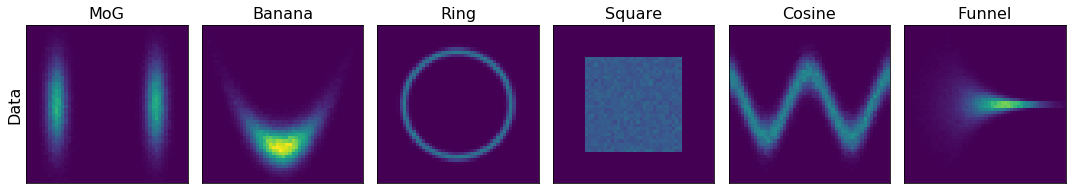

In [6]:
from matplotlib import cm
from matplotlib.colors import Normalize

name_to_title = OrderedDict([
    ('grid', 'MoG'),
    ('banana','Banana'),
    ('rings', 'Ring'),
    ('uniform', 'Square'),
    ('cosine', 'Cosine'),
    ('funnel', 'Funnel')
])

name_to_xlim = OrderedDict([
    ('grid', [-6.5, 6.5]),
    ('banana', [-7.5, 7.5]),
    ('rings', [-7.5, 7.5]),
    ('uniform', [-5, 5]),
    ('cosine', [-3, 3]),
    ('funnel', [-6, 6])
])

name_to_ylim = OrderedDict([
    ('grid', [-1.5, 1.5]),
    ('banana', [-4, 10]),
    ('rings', [-7.5, 7.5]),
    ('uniform', [-5, 5]),
    ('cosine', [-7.5, 7.5]),
    ('funnel', [-10, 10])
])

name_to_vmax = OrderedDict([
    ('grid', 0.5),
    ('banana', 0.08),
    ('rings', 0.15),
    ('uniform', 0.1),
    ('cosine', 0.15),
    ('funnel', 0.15)
])

fig = plt.figure(figsize=(15, 2.8))

for i, (k, v) in enumerate(name_to_dataset.items()):
    ax = fig.add_subplot(1, 6, 1+i)
    G_x = v().sample(100000)
    
    
    h = plt.hist2d(G_x[:, 0], G_x[:, 1], range=(name_to_xlim[k], name_to_ylim[k]), bins=50, density=True, vmin=0.0, vmax=name_to_vmax[k])
    plt.title(name_to_title[k], size=16)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Data', size=16) 
plt.tight_layout()
# plt.savefig('syn_data.pdf', bbox_inches='tight')

In [7]:
name_to_title = OrderedDict([
    ('grid', 'MoG'),
    ('banana','Banana'),
    ('rings', 'Ring'),
    ('uniform', 'Square'),
    ('cosine', 'Cosine'),
    ('funnel', 'Funnel')
])

name_to_xlim = OrderedDict([
    ('grid', [-6.5, 6.5]),
    ('banana', [-7.5, 7.5]),
    ('rings', [-7.5, 7.5]),
    ('uniform', [-5, 5]),
    ('cosine', [-3, 3]),
    ('funnel', [-6, 6])
])

name_to_ylim = OrderedDict([
    ('grid', [-1.5, 1.5]),
    ('banana', [-4, 10]),
    ('rings', [-7.5, 7.5]),
    ('uniform', [-5, 5]),
    ('cosine', [-7.5, 7.5]),
    ('funnel', [-10, 10])
])

name_to_vmax = OrderedDict([
    ('grid', 0.5),
    ('banana', 0.08),
    ('rings', 0.15),
    ('uniform', 0.1),
    ('cosine', 0.15),
    ('funnel', 0.15)
])

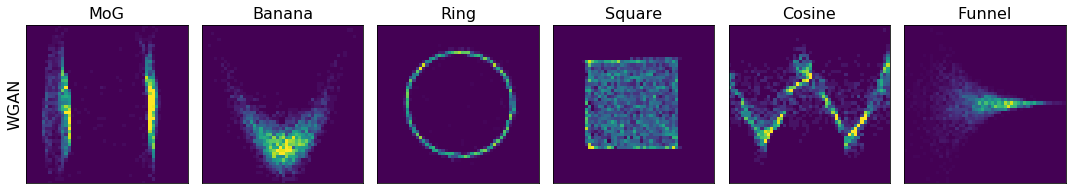

In [8]:
fig = plt.figure(figsize=(15, 2.8))

for i, (k, v) in enumerate(name_to_dataset.items()):
    ax = fig.add_subplot(1, 6, 1+i)
    G_x = np.load(f'save_0/{k}_hinge.npy')
    plt.hist2d(G_x[:, 0], G_x[:, 1], range=(name_to_xlim[k], name_to_ylim[k]), bins=50, density=True, vmin=0.0, vmax=name_to_vmax[k])
    plt.title(name_to_title[k], size=16)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('WGAN', size=16) 
plt.tight_layout()
# plt.savefig('syn_wgan.pdf', bbox_inches='tight')

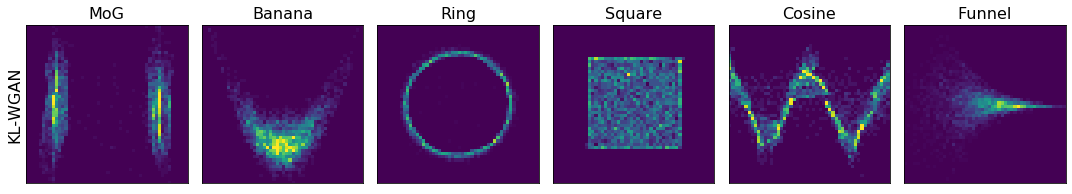

In [9]:
fig = plt.figure(figsize=(15, 2.8))

for i, (k, v) in enumerate(name_to_dataset.items()):
    ax = fig.add_subplot(1, 6, 1+i)
    G_x = np.load(f'save_2/{k}_kl.npy')
    plt.hist2d(G_x[:, 0], G_x[:, 1], range=(name_to_xlim[k], name_to_ylim[k]), bins=50, density=True, vmin=0.0, vmax=name_to_vmax[k])
    plt.title(name_to_title[k], size=16)
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('KL-WGAN', size=16) 
plt.tight_layout()
# plt.savefig('syn_klwgan.pdf', bbox_inches='tight')

46
29
181
100
55
7


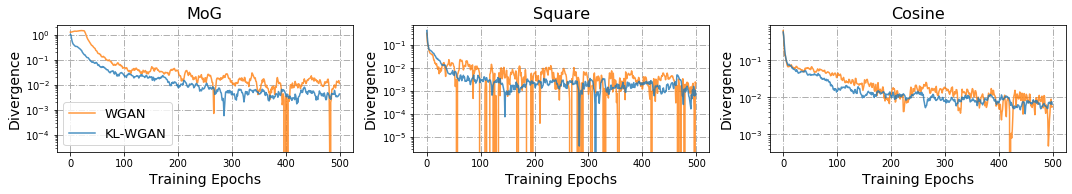

In [11]:
import seaborn as sns
import pandas as pd
colors = sns.color_palette()
fig = plt.figure(figsize=(15, 2.8))
EMA_SPAN = 9

for i, name in enumerate(['grid', 'uniform', 'cosine']):
    ax = fig.add_subplot(1, 3, 1+i)
    
    kl = np.load(f'save_0/{name}_hinge.obj.npy')
    print(np.sum(kl < 0))
    kl = pd.Series(kl).ewm(span=EMA_SPAN).mean()
    kl_std = pd.Series(kl).ewm(span=EMA_SPAN).std()
    kl_std[0] = 0.0
    plt.plot(kl, label='WGAN', color=colors[1], alpha=0.8)
#     plt.fill_between(np.arange(0, kl.shape[0]), kl - kl_std, kl + kl_std, color=colors[1], alpha=0.3)
    
    kl = np.load(f'save_0/{name}_kl.obj.npy')
    print(np.sum(kl < 0))
    kl = pd.Series(kl).ewm(span=EMA_SPAN).mean()
    kl_std = pd.Series(kl).ewm(span=EMA_SPAN).std()
    kl_std[0] = 0.0
    plt.plot(kl, label='KL-WGAN', color=colors[0], alpha=0.8)
#     plt.fill_between(np.arange(0, kl.shape[0]), kl - kl_std, kl + kl_std, color=colors[0], alpha=0.3)
    
    
    plt.yscale('log')
    plt.title(name_to_title[name], size=16)
    plt.xlabel('Training Epochs', size=14)
    plt.ylabel('Divergence', size=14)
    plt.grid(linestyle='-.', linewidth=1)
    
    if i == 0:
        plt.legend(prop={'size': 13})
plt.tight_layout()
# plt.savefig('div_curve.pdf', bbox_inches='tight')